# Generative Adversarial Networks in Slanted Land

In this notebook, we build a very simple pair of GANs.
- The dataset is a dataset of 2x2 black and white images, where the images we want to generate (the faces) are backwards diagonals (\\)
- The neural networks only have one layer.

Below is the YouTube video corresponding to this notebook.

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/watch?v=8L11aMN5KY8" frameborder="0" allowfullscreen></iframe>')

C:\Users\sleam\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Imports

In [2]:
# Imports

import numpy as np
from numpy import random
from matplotlib import pyplot as plt
%matplotlib inline

### Plotting function

In [3]:
# Drawing function

def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

# Examples of faces

In the video, we've defined the faces as backwards diagonals. Here are some examples.

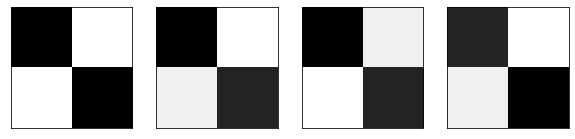

In [4]:
# Examples of faces
faces = [np.array([1,0,0,1]),
         np.array([0.9,0.1,0.2,0.8]),
         np.array([0.9,0.2,0.1,0.8]),
         np.array([0.8,0.1,0.2,0.9]),
         np.array([0.8,0.2,0.1,0.9])]
    
_ = view_samples(faces, 1, 4)

# Examples of noise
The following are randomly generated images, which don't correspond to faces.

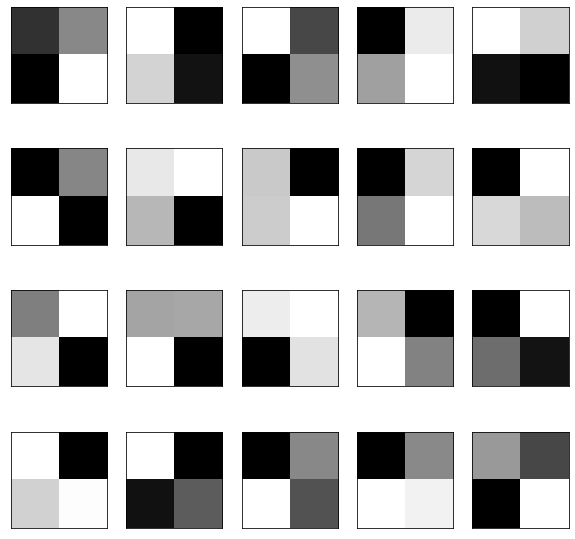

In [5]:
# Examples of noisy images
noise = [np.random.randn(2,2) for i in range(20)]
def generate_random_image():
    return [np.random.random(), np.random.random(), np.random.random(), np.random.random()]

_ = view_samples(noise, 4,5)

# Building the neural networks

In [6]:
# The sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

## The Discriminator

<img src="discriminator_math.png" />

In [7]:
class Discriminator():
    def __init__(self):
        #self.weights = np.array([0.0 for i in range(4)])
        #self.bias = 0.0
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
    
    def forward(self, x):
        # Forward pass
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_from_image(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    def derivatives_from_image(self, image):
        prediction = self.forward(image)
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias
    
    def update_from_image(self, x):
        ders = self.derivatives_from_image(x)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-prediction)
    
    def derivatives_from_noise(self, noise):
        prediction = self.forward(noise)
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias
    
    def update_from_noise(self, noise):
        ders = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

## The Generator
<img src="generator_math.png" />

In [8]:
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])

    def forward(self, z):
        # Forward pass
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        error_before = self.error(z, discriminator)
        ders = self.derivatives(z, discriminator)
        self.weights -= learning_rate * ders[0]
        self.biases -= learning_rate * ders[1]
        error_after = self.error(z, discriminator)

# Training

In [9]:
# Set random seed
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces:
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

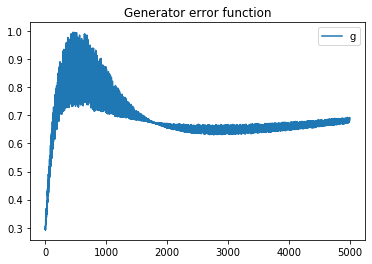

Text(0.5, 1.0, 'Discriminator error function')

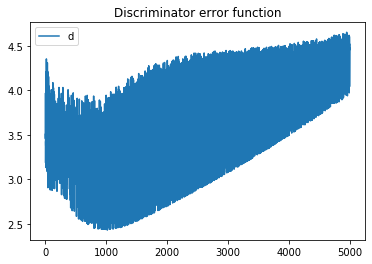

In [10]:
import matplotlib.pyplot as plt
plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

# Generating images

[0.94688171 0.03401213 0.04080795 0.96308679]
[0.95653992 0.03437852 0.03579494 0.97063836]
[0.95056667 0.03414339 0.03893305 0.96599501]
[0.94228203 0.03386046 0.04309146 0.95941292]


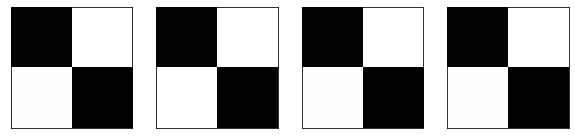

In [11]:
generated_images = []
for i in range(4):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

# Studying the weights and biases of the Generator and Discriminator

In [12]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 0.70702123  0.03720449 -0.45703394  0.79375751]
Generator biases [ 2.48490157 -3.36725912 -2.90139211  2.8172726 ]


In [13]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.60175083 -0.29127513 -0.40093314  0.37759987]
Discriminator bias -0.8955103005797729
